# Graph kernels with PASQAL processor

In [1]:
import numpy as np
from utils import return_list_of_states, return_energy_distribution, return_js_matrix
from qutip import mcsolve, sesolve, sigmaz, sigmap, qeye, tensor, Options, expect, sigmam
from data_preprocessing import load_dataset
import pickle
import networkx as nx
import grakel
import matplotlib.pyplot as plt
from time import time

from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV
from skopt import gp_minimize

## Import the IMDB-MULTI dataset

We import the IMDB-MULTI dataset, limited to the graphs below 12 nodes. For the rest of the demo, we will limit ourselves to a sample of 150 graphs

Number of graphs:  1001


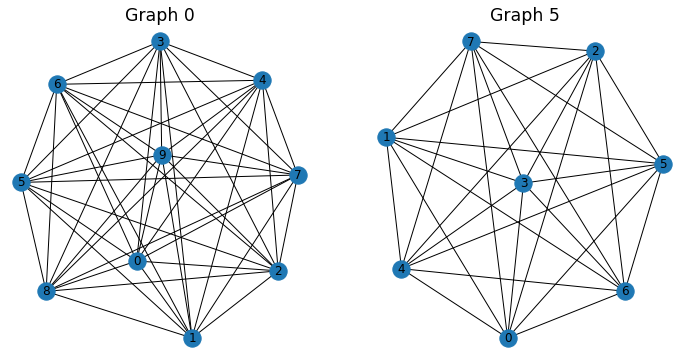

In [2]:
graphs, targets = load_dataset('IMDB-MULTI', min_node=0, max_node=12)
print("Number of graphs: ", len(graphs))

np.random.seed(40)
N_sample = 150
sample = np.random.choice(len(graphs), size=N_sample, replace=False).astype(int)

graphs_sample, targets_sample = graphs[sample], targets[sample]
graphs_sample = [nx.convert_node_labels_to_integers(G) for G in graphs_sample]
graphs_sample = np.array(graphs_sample, dtype=object)

plt.figure(figsize=[12,6])
plt.subplot(121)
nx.draw(graphs_sample[0], with_labels=True)
plt.title("Graph 0", fontsize='xx-large')
plt.subplot(122)
nx.draw(graphs_sample[5], with_labels=True)
plt.title("Graph 5", fontsize='xx-large')
plt.show()

## Generate the hamiltonian evolutions

We describe here how to perform a graph classification for specific values of times and pulses for a 2 layers ising evolution.

Generate the final states of all graphs 

In [3]:
times = [2.1, 1.6]
pulses = [0.2, 0.1]

states = return_list_of_states(graphs_sample, times, pulses, evol='ising')

Plot some final states after evolution

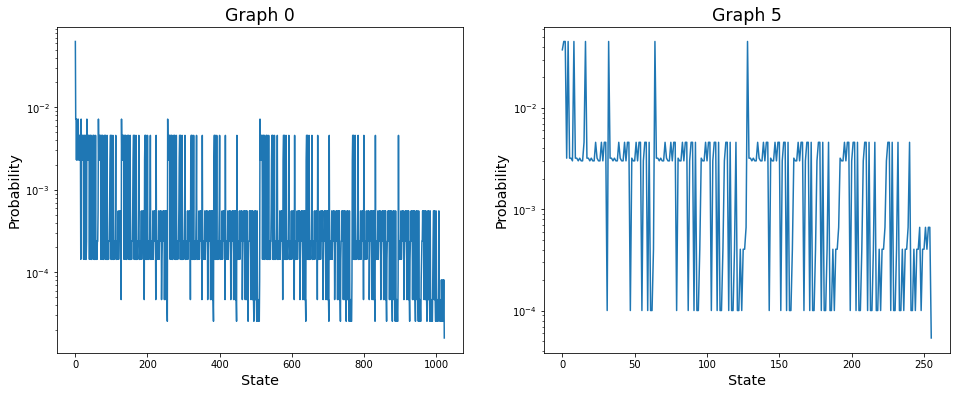

In [4]:
plt.figure(figsize=[16,6])
plt.subplot(121)
prob = np.abs(states[0].data.toarray())**2
plt.plot(prob)
plt.yscale('log')
plt.xlabel('State', fontsize='x-large')
plt.ylabel('Probability', fontsize='x-large')
plt.title("Graph 0", fontsize='xx-large')
plt.subplot(122)
prob = np.abs(states[5].data.toarray())**2
plt.plot(prob)
plt.yscale('log')
plt.xlabel('State', fontsize='x-large')
plt.ylabel('Probability', fontsize='x-large')
plt.title("Graph 5", fontsize='xx-large')
plt.show()

Compute the probability distribution of the Ising observable from each state. First we compute the observables of each graph separately and we store them in a dictionnary.

In [5]:
def observable(graph):
    N = graph.number_of_nodes()

    si = qeye(2)
    sp = sigmap()
    sm = sigmam()

    sz = sigmaz()

    sp_list = []
    sz_list = []
    sm_list = []
    sn_list = []

    for j in range(N):
        op_list = [si for _ in range(N)]

        op_list[j] = sp
        sp_list.append(tensor(op_list))

        op_list[j] = sm
        sm_list.append(tensor(op_list))

        op_list[j] = sz
        sz_list.append(tensor(op_list))

        op_list[j] = 0.5 * (sz + si)
        sn_list.append(tensor(op_list))

    # construct the hamiltonian
    H = 0

    for node in graph.nodes.data():
        # node_weight = graph.degree[node[0]]
        node_weight = 0
        H += node_weight * sz_list[node[0]]

    for edge in graph.edges.data():
        edge_weight = 1
        H += edge_weight * sz_list[edge[0]] * sz_list[edge[1]]

    return H


from utils import Memoizer
observables_memoizer = Memoizer(observable)

Compute the probability distribution and the distance matrix

In [6]:
energies = return_energy_distribution(graphs_sample, states, observables_memoizer.get_observable)
matrix = return_js_matrix(energies)

Fit the model

In [7]:
K = np.exp(-matrix)
C_list = np.logspace(-3, 3, 7)

param_grid = {'C': C_list}
scoring = {'accuracy': make_scorer(accuracy_score),
            'f1_score': make_scorer(f1_score, average='weighted')
            }

skf = RepeatedStratifiedKFold(10, 10, random_state=47)

estimator = svm.SVC(kernel='precomputed', random_state=76)

grid_search = GridSearchCV(estimator, param_grid, scoring=scoring,
                                cv=skf, refit=False, n_jobs=-1)
result = grid_search.fit(K, targets_sample).cv_results_

i_best = np.argmax(result['mean_test_accuracy'])
print('Accuracy: ', result['mean_test_accuracy'][i_best], '±', result['std_test_accuracy'][i_best])


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy:  0.44000000000000006 ± 0.13131810402394806


## Find the best parameters

Now we look for the values of times and pulses to get the best accuracy score. This is done by bayesian optimization.

Define the score function

In [8]:
def get_score(param):
    middle = len(param)//2
    states = return_list_of_states(graphs_sample, param[0:middle], param[middle::], evol='ising')
    energies = return_energy_distribution(graphs_sample, states, observables_memoizer.get_observable)
    matrix = return_js_matrix(energies)
    K = np.exp(-matrix)
    C_list = np.logspace(-3, 3, 7)

    param_grid = {'C': C_list}
    scoring = {'accuracy': make_scorer(accuracy_score),
                'f1_score': make_scorer(f1_score, average='weighted')
                }

    skf = RepeatedStratifiedKFold(10, 10, random_state=47)

    estimator = svm.SVC(kernel='precomputed', random_state=76)

    grid_search = GridSearchCV(estimator, param_grid, scoring=scoring,
                                    cv=skf, refit=False, n_jobs=-1)
    result = grid_search.fit(K, targets_sample).cv_results_

    return -np.max(result['mean_test_accuracy'])
    


Run the bayesian optimization (can take up to 15 min)

In [9]:
bounds = [(0., 3.)] * 2 + [(0., 1.)] * 2
    
opt_result = gp_minimize(
    get_score,
    bounds,
    acq_func='LCB',
    n_calls=30,
    n_initial_points=20,
    acq_optimizer='sampling',
    n_points=5000,
    kappa=4,
    n_jobs=-1)

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/Use

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/Use

In [10]:
i_best = np.argmin(opt_result.func_vals)
print('Best accuracy: ', np.abs(opt_result.func_vals[i_best]))
print('Best parameters: ', opt_result.x_iters[i_best])


Best accuracy:  0.4553333333333333
Best parameters:  [2.315621722480806, 1.2265746859785436, 0.953602947535717, 0.013760587574968012]
